In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as matimage
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [2]:
train_samples= 5000

In [3]:
X, y = fetch_openml(name="Fashion-MNIST",  return_X_y=True)

In [4]:
X.shape

(70000, 784)

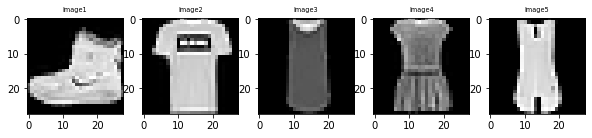

In [5]:
n_row = 1
n_col = 5
plt.figure(figsize=(10,8))
for i in list(range(n_row*n_col)):
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(X[i,:].reshape(28,28), cmap="gray")
    title_text = "Image" + str(i+1)
    plt.title(title_text, size=6.5)

plt.show()

### Using Scaler to ensure that all the values are centered around the mean value of 0

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
X  = StandardScaler().fit_transform(X)

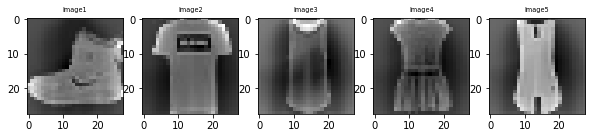

In [8]:
n_row = 1
n_col = 5
plt.figure(figsize=(10,8))
for i in list(range(n_row*n_col)):
    plt.subplot(n_row, n_col, i+1)
    plt.imshow(X[i,:].reshape(28,28), cmap="gray")
    title_text = "Image" + str(i+1)
    plt.title(title_text, size=6.5)

plt.show()

# Lets split the data into Training set and Test set

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    train_size=train_samples, 
    test_size=1000)

# Using Decision Tree Classifier

In [10]:
from sklearn.tree import DecisionTreeClassifier

In [11]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train,y_train)
dtc_predict = dtc.predict(X_test)

print(classification_report(y_test, dtc_predict))
accuracy = accuracy_score(y_test, dtc_predict)
average_accuracy = np.mean(y_test == dtc_predict) * 100
print("The average_accuracy is {0:.1f}%".format(average_accuracy))

              precision    recall  f1-score   support

           0       0.72      0.67      0.70        92
           1       0.86      0.96      0.91       100
           2       0.50      0.55      0.52       100
           3       0.71      0.73      0.72       105
           4       0.64      0.59      0.61       110
           5       0.83      0.78      0.80        97
           6       0.44      0.41      0.42       102
           7       0.74      0.81      0.77        86
           8       0.86      0.80      0.83       112
           9       0.88      0.86      0.87        96

   micro avg       0.72      0.72      0.72      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.72      0.72      0.72      1000

The average_accuracy is 71.6%


# Using Random Forest Classifier 

In [12]:
from sklearn.ensemble import RandomForestClassifier

In [13]:
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
rfc_predict = rfc.predict(X_test)

print(classification_report(y_test, rfc_predict))
accuracy = accuracy_score(y_test, rfc_predict)
average_accuracy = np.mean(y_test == rfc_predict) * 100
print("The average_accuracy is {0:.1f}%".format(average_accuracy))

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.77      0.83      0.80        92
           1       0.97      0.94      0.95       100
           2       0.67      0.75      0.71       100
           3       0.73      0.84      0.78       105
           4       0.73      0.67      0.70       110
           5       0.92      0.92      0.92        97
           6       0.66      0.49      0.56       102
           7       0.87      0.88      0.88        86
           8       0.94      0.96      0.95       112
           9       0.93      0.92      0.92        96

   micro avg       0.82      0.82      0.82      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.82      0.82      0.82      1000

The average_accuracy is 81.8%


In [1]:
import logging

from matplotlib import pyplot as plt
import pandas as pd
import os

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.core.dataset import Dataset
from azureml.train.automl import AutoMLConfig

In [2]:
ws = Workspace.from_config()

In [4]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget

# Choose a name for your AmlCompute cluster.
amlcompute_cluster_name = "cpu-cluster-2"

found = False
# Check if this compute target already exists in the workspace.
cts = ws.compute_targets
if amlcompute_cluster_name in cts and cts[amlcompute_cluster_name].type == 'cpu-cluster-2':
    found = True
    print('Found existing compute target.')
    compute_target = cts[amlcompute_cluster_name]
    
if not found:
    print('Creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = "STANDARD_DS13_V2", # for GPU, use "STANDARD_NC6"
                                                                #vm_priority = 'lowpriority', # optional
                                                                max_nodes = 2)

    # Create the cluster.
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, provisioning_config)
    
print('Checking cluster status...')
# Can poll for a minimum number of nodes and for a specific timeout.
# If no min_node_count is provided, it will use the scale settings for the cluster.
compute_target.wait_for_completion(show_output = True, min_node_count = None, timeout_in_minutes = 20)

# For a more detailed view of current AmlCompute status, use get_status().

Creating a new compute target...
Checking cluster status...
Succeeded
AmlCompute wait for completion finished
Minimum number of nodes requested have been provisioned


In [5]:
dataset = Dataset.get_by_name(ws, name='fashion-mnist_train-z0xtwetdg9')

In [9]:
training_data, validation_data = dataset.random_split(percentage=0.08, seed=7388)
label_column_name = 'label'

In [10]:
automl_settings = {
    "n_cross_validations": 3,
    "primary_metric": 'accuracy',
    "preprocess": True,
    "enable_early_stopping": True,
    "max_concurrent_iterations": 3, # This is a limit for testing purpose, please increase it as per cluster size
    "experiment_timeout_minutes": 60, # This is a time limit for testing purposes, remove it for real use cases, this will drastically limit ablity to find the best model possible
    "verbosity": logging.INFO,
}

automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             compute_target = compute_target,
                             training_data = training_data,
                             label_column_name = label_column_name,
                             **automl_settings
                            )

In [11]:
# choose a name for experiment
experiment_name = 'automl-classification-fashion'

experiment=Experiment(ws, experiment_name)

In [12]:
remote_run = experiment.submit(automl_config, show_output = False)

In [13]:
from azureml.widgets import RunDetails
RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'NOTSET', …